In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# The function used to generate data, the Runge function
def Runge_func(x):
    return 1.0/(1 + 25*x**2)

In [3]:
# Functions used

def polynomial_features(x, p, intercept=False):
    """
    Take an array of x values, and the desired polynomial degree p.
    Create a feature (design) matrix with first column x**1, second column with x**2, and so on. I.e. the i-th column containing x**(i+1).
    Intercept=True will turn the first column into ones, meaning the i-th column will contain the value x**(j).
    """
    n = len(x)
    x = x.ravel()
    if intercept  == True:
        X = np.zeros((int(n), int(p + 1)))
        for i in range(0, int(p+1)):
            X[:, i] = x**i  # Create first column with only ones (since x**0 = 1), the intercept column
    else:
        X = np.zeros((int(n), int(p)))
        for i in range(0, int(p)):
            X[:, i] = x**(i+1)
    return X

def OLS_parameters(X, y):
    """
    The closed form solution of least square optimization.
    Take a feature matrix X, and a column vector y.
    Return the parameters of OLS fit.
    """
    # The inverse of matrix X, using .pinv in case X is not square
    # The beta vector in: X @ beta = y, solved for beta
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y   
    return beta

def Ridge_parameters(X, y, ridge_lambda):
    """
    The closed form solution of Ridge optimization.
    Take a feature matrix X, and a column vector y, and the Ridge lambda parameter.
    Return the beata parameters of the Ridge fit.
    """
    # Assumes X is scaled and has no intercept column
    I = np.identity(np.shape(X)[1])    # Create identity matrix same shape as X.T @ X, columns of X decide the shape, (nxm)(mxn)=(nxn)
    # Element-wise multiplication with *
    beta = np.linalg.pinv(X.T @ X + ridge_lambda*I) @ X.T @ y
    return beta

In [52]:
# Bias-variance-tradeoff, using bootstrap and Ridge

# Setting up dataset
np.random.seed(2025)
n = 1000
std = 0.1
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, std, size=n)

x = x.reshape(-1,1)
y = y.reshape(-1,1)

ridge_lambda = 1e-4

bootstraps = 1000

max_degree = 30
poly_degrees = np.arange(1, max_degree + 1, 1)

biases_train = np.zeros(max_degree)
variances_train = np.zeros(max_degree)
MSEs_train = np.zeros(max_degree)

biases_test = np.zeros(max_degree)
variances_test = np.zeros(max_degree)
MSEs_test = np.zeros(max_degree)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
y_center = np.mean(y_train)

for degree in range(len(poly_degrees)):
    X_train = polynomial_features(x_train, poly_degrees[degree], intercept=False)
    X_test = polynomial_features(x_test, poly_degrees[degree], intercept=False)

    # Scaling of the data
    scaler = StandardScaler()   # initialize scaler method
    scaler.fit(X_train)               # only base the scaling on X_train, to prevent data leakage from X_test 
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # predictions are later filled with predictions made from X_test (feature matrix), constructed from x_test, 
    # so got to have same length
    predictions_train = np.zeros([bootstraps, len(x_train)])
    predictions_test = np.zeros([bootstraps, len(x_test)])

    for b in range(bootstraps):
        # For each bootstrap sample of X_train and Y_train, we train model, predict on X_test
        # Later comparing against the un-touched y_test
        X_train_resampled, y_train_resampled = resample(X_train_s, y_train)

        # Training the model on training data
        beta = Ridge_parameters(X_train_resampled, y_train_resampled, ridge_lambda=ridge_lambda)
        
        # Making the prediction on train data
        pred_train = X_train_s @ beta + y_center
        predictions_train[b,:] = pred_train.ravel()
        
        # Making the prediction on test data
        pred_test = X_test_s @ beta
        predictions_test[b,:] = pred_test.ravel() + y_center

    # We take the true values or target, as the un-tough values in the y_test split
    # The predicted y values, lives in the predictions matrix, where each row is a sample of values,
    # and each column corresponding to a one y point across bootstrap samples
    biases_train[degree] = np.mean((y_train.T - np.mean(predictions_train, axis=0))**2)
    biases_test[degree] = np.mean((y_test.T - np.mean(predictions_test, axis=0))**2)

    # Var(prediction) is the mean of the flatend matrix, over all samples
    variances_train[degree] = np.mean((predictions_train - np.mean(predictions_train, axis=0))**2)
    variances_test[degree] = np.mean((predictions_test - np.mean(predictions_test, axis=0))**2)

    # For the MSE, we take difference of each y point per bootstrap sample, making y_test a row vector
    # then squaring, before taking the mean over the flattened matrix
    MSEs_train[degree] = np.mean(np.mean((predictions_train - y_train.T)**2, axis=1), axis=0)
    MSEs_test[degree] = np.mean(np.mean((predictions_test - y_test.T)**2, axis=1), axis=0)


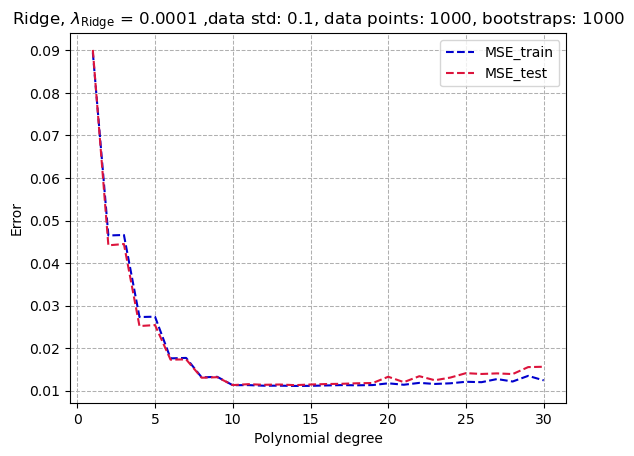

In [53]:
# plt.plot(poly_degrees, biases_train, "-", color="mediumblue", label="Bias_train")
# plt.plot(poly_degrees, variances_train, ":", color="mediumblue", label="Variance_train")
plt.plot(poly_degrees, MSEs_train, "--", color="mediumblue", label="MSE_train")
# plt.plot(poly_degrees, biases_test, "-", color="crimson", label="Bias_test")
# plt.plot(poly_degrees, variances_test, ":", color="crimson", label="Variance_test")
plt.plot(poly_degrees, MSEs_test, "--", color="crimson", label="MSE_test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title(f"Ridge, $\lambda_{{\\text{{Ridge}}}}$ = {ridge_lambda} ,data std: {std}, data points: {n}, bootstraps: {bootstraps}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
#plt.savefig("bias_var_tradeoff.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


# The function used to generate data, the Runge function
def Runge_func(x):
    return 1.0/(1 + 25*x**2)

np.random.seed(2025)

# Setting up data
n = 1000
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, 0.1, size=n)

max_poly_degree = 30
poly_degrees = np.arange(1, max_poly_degree + 1, 1)

ridge_lambda = 1e-6

## Cross-validation on Ridge regression using repeated KFold
# Initialize a rKFold instance
k = 10
k_n = 1
rkfold = RepeatedKFold(n_splits=k, n_repeats=k_n)

# Perform the cross-validation to estimate MSE
#scores_KFold = np.zeros((nlambdas, k))
n_rkfolds = rkfold.get_n_splits()

biases_train = np.zeros(max_poly_degree)
variances_train = np.zeros(max_poly_degree)
MSEs_train = np.zeros(max_poly_degree)

biases_test = np.zeros(max_poly_degree)
variances_test = np.zeros(max_poly_degree)
MSEs_test = np.zeros(max_poly_degree)

scores_rKFold_train = np.zeros((len(poly_degrees), n_rkfolds))
scores_rKfold_test = np.zeros((len(poly_degrees), n_rkfolds))

for degree in range(len(poly_degrees)):

    # predictions_train = np.zeros([k*k_n])
    # predictions_test = np.zeros([k*k_n])

    j = 0
    for train_inds, test_inds in rkfold.split(x):
        x_train = x[train_inds]
        y_train = y[train_inds]
        x_test = x[test_inds]
        y_test = y[test_inds]
        
        y_train_center = np.mean(y_train)

        X_train = polynomial_features(x_train, poly_degrees[degree], intercept=False)
        X_test = polynomial_features(x_test, poly_degrees[degree], intercept=False)

        # Scaling of the data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        beta = Ridge_parameters(X_train_s, y_train, ridge_lambda=ridge_lambda)
        predictions_train = X_train_s @ beta + y_train_center
        predictions_test = X_test_s @ beta + y_train_center

        # We take the true values or target, as the un-tough values in the y_test split
        # The predicted y values, lives in the predictions matrix, where each row is a sample of values,
        # and each column corresponding to a one y point across bootstrap samples
        biases_train[degree] = np.mean((y_train - np.mean(predictions_train, axis=0))**2)
        biases_test[degree] = np.mean((y_test - np.mean(predictions_test, axis=0))**2)

        # Var(prediction) is the mean of the flatend matrix, over all samples
        variances_train[degree] = np.mean((predictions_train - np.mean(predictions_train, axis=0))**2)
        variances_test[degree] = np.mean((predictions_test - np.mean(predictions_test, axis=0))**2)

        # For the MSE, we take difference of each y point per bootstrap sample, making y_test a row vector
        # then squaring, before taking the mean over the flattened matrix
        MSEs_train[degree] = np.mean(np.mean((predictions_train - y_train)**2))#, axis=1), axis=0)
        MSEs_test[degree] = np.mean(np.mean((predictions_test - y_test)**2))#, axis=1), axis=0)

        scores_rKFold_train[degree,j] = np.mean((predictions_train - y_train)**2)
        scores_rKfold_test[degree,j] = np.mean((predictions_test - y_test)**2)
        j += 1

estimated_mse_rKFold_train = np.mean(scores_rKFold_train, axis=1)
estimated_mse_rKFold_test = np.mean(scores_rKfold_test, axis=1)


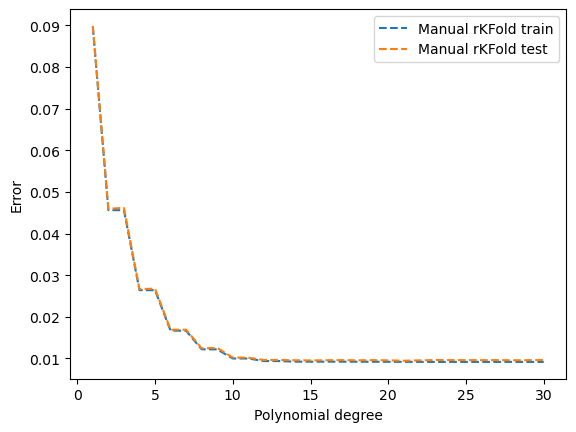

In [7]:
plt.plot(poly_degrees, estimated_mse_rKFold_train, '--', label='Manual rKFold train')
plt.plot(poly_degrees, estimated_mse_rKFold_test, '--', label='Manual rKFold test')

plt.xlabel('Polynomial degree')
plt.ylabel('Error')

plt.legend()

plt.show()

NameError: name 'std' is not defined

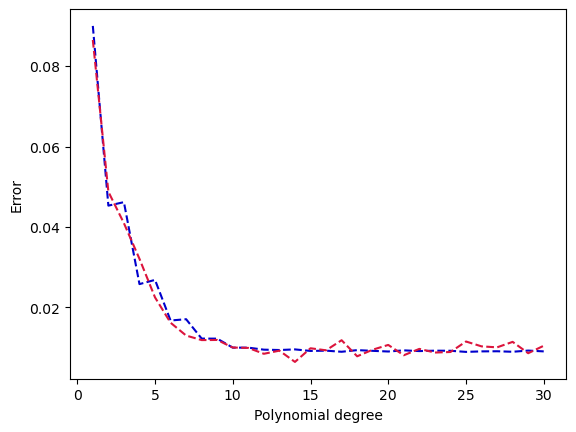

In [8]:
# plt.plot(poly_degrees, biases_train, "-", color="mediumblue", label="Bias_train")
# plt.plot(poly_degrees, variances_train, ":", color="mediumblue", label="Variance_train")
plt.plot(poly_degrees, MSEs_train, "--", color="mediumblue", label="MSE_train")
# plt.plot(poly_degrees, biases_test, "-", color="crimson", label="Bias_test")
# plt.plot(poly_degrees, variances_test, ":", color="crimson", label="Variance_test")
plt.plot(poly_degrees, MSEs_test, "--", color="crimson", label="MSE_test")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title(f"Ridge, $\lambda_{{\\text{{Ridge}}}}$ = {ridge_lambda} ,data std: {std}, data points: {n}, k-folds: {k}, and refolds: {k_n}")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
#plt.savefig("bias_var_tradeoff.pdf", bbox_inches="tight")
plt.show()
plt.close()